In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# preparing our dataset by combining data from different sources

df= pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\yt_cleaned_110319_071122.xlsx')

# In case of this dataset blank cell means 0;

df = df.fillna(0)
df.index=df.date
df['sum'] = df.sum(numeric_only=True, axis=1)

# joining data from another file with average time of online course videos watched on linked_in learning;
# filling null values with mean or 0 depending on date column
# the second file starts in 2021 while main df samples start from 2019, thus we need to fill in na values again

df = df['sum'].reset_index()
# linked_in_learning_df = pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\linked_in_learning.xlsx')
# df = pd.merge(df,linked_in_learning_df,on='date',how='left')


# joining data from yet another file containing the amount of working hours

working_hours_df = pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\work_hours.xlsx')
df = pd.merge(df,working_hours_df,on='date',how='left')
df.fillna(0, inplace = True)

# joining data from another file with average activity; the column shows a mean number of steps walked each month since April 2021;
# second file starts in 2021 while main df samples start from 2019, thus we need to fill in na values again
# we decide to fill the missing values values for working days with the distance between home and work place,
# for other place 1/3 of that distance  

steps = pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\steps.xlsx')
df = pd.merge(df,steps,on='date',how='left')
df['mean_steps'] = np.where((df['work_hours']!=0) & (df['date']<pd.to_datetime('12-01-2019')) & (df['date']>pd.to_datetime('06-01-2019')),2000, df['mean_steps'])
df['mean_steps'] = df['mean_steps'].fillna(600)

# reseting index to be able to use date column
df = df.reset_index().drop(['index'], axis = 1)

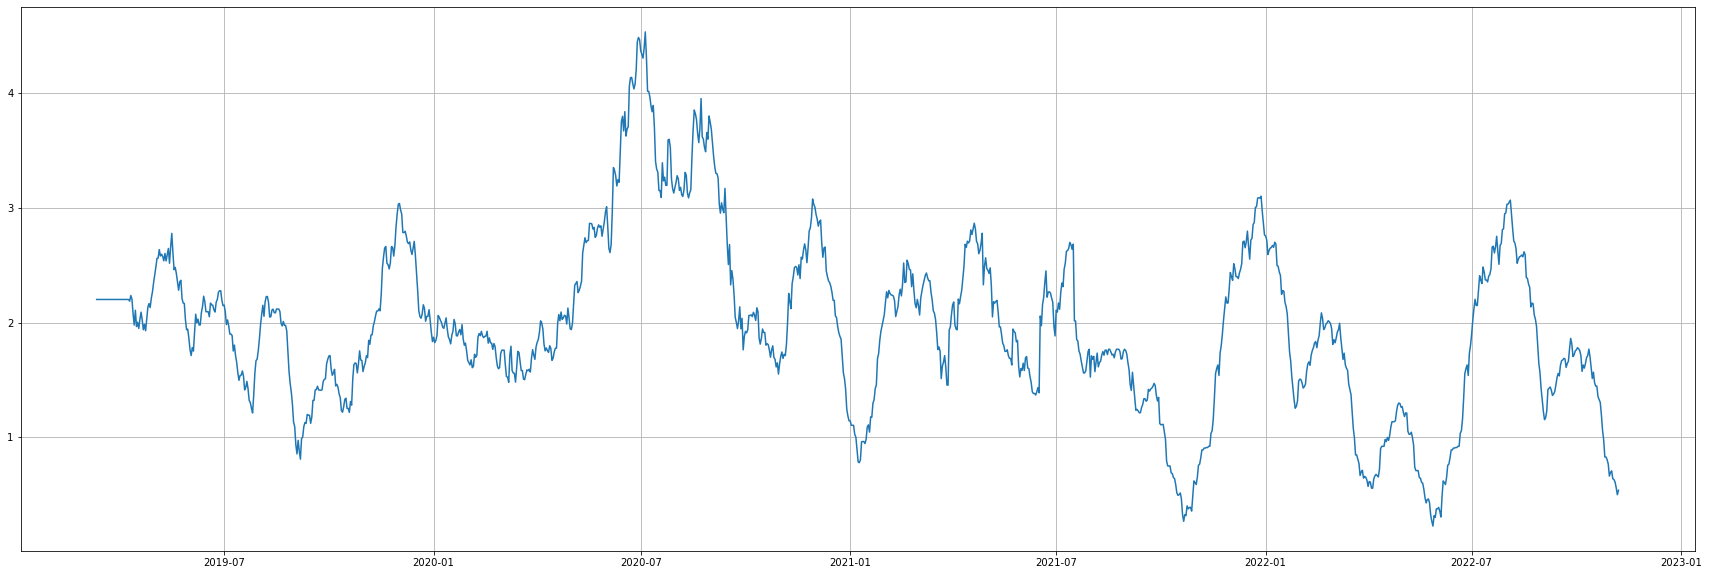

In [3]:
# Our main file is a timeseries, but as we have features(and will create new ones) that are not time dependent,
# we will frame our problem as unsupervised learning (clustering)
# calculating moving average for the sum column to see overall and seasonal trends more clearly

import datetime as dt

df['rolling30'] = df['sum'].rolling(30).mean()
df = df.fillna(np.mean(df['sum'][0:29]))
dates = df['date'][df['date'].dt.day==11].reset_index(drop=True)
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(df['date'], df['rolling30'])
plt.grid(True)

# We see biggest peaks in summer and smaller peaks in winter
# the general trend seems to be slightly decreasing

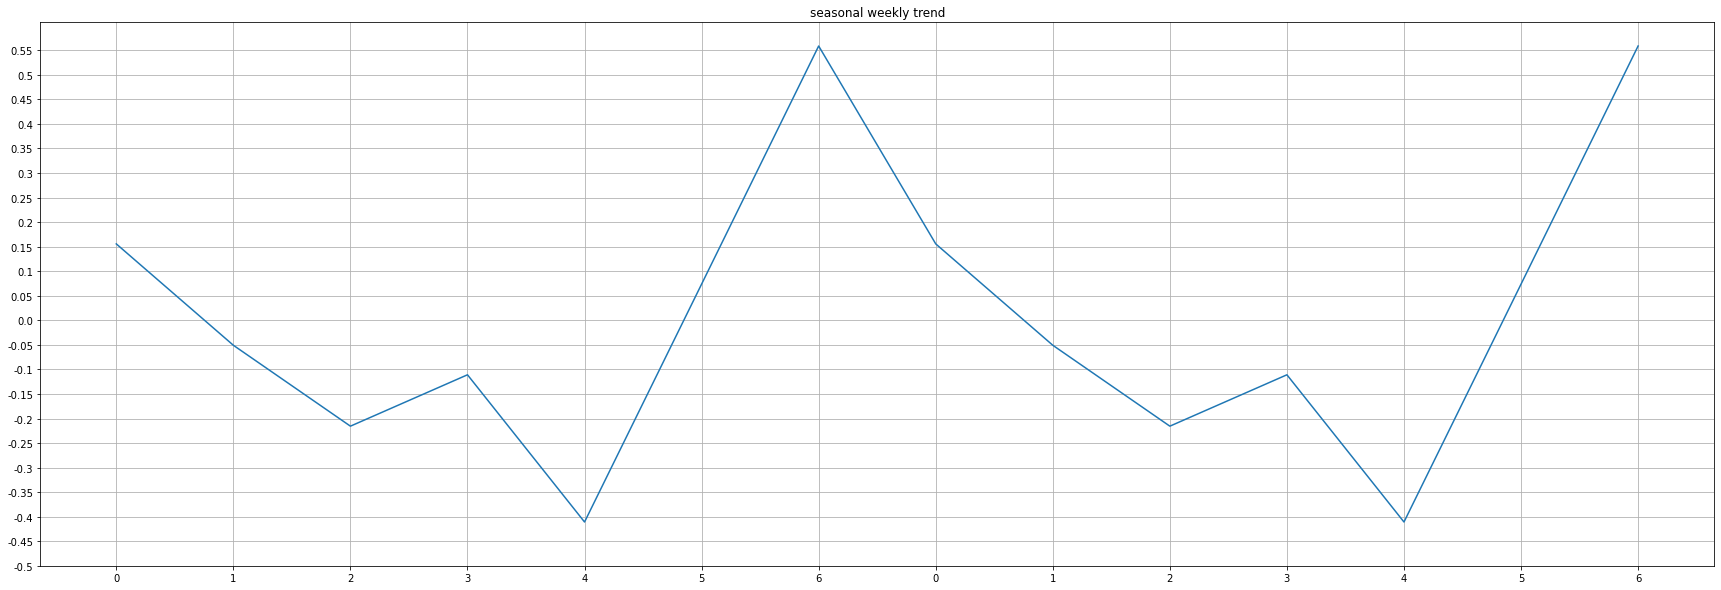

In [4]:
# Time series decomposition, to do a more profound check for seasonal and general trend and for residual component;

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['sum'], model='additive',period=7)
plt.rcParams["figure.figsize"] = (30,10)
# plt.plot(df['date'],result.observed.values)
plt.plot(df['date'][14:28],result.seasonal[14:28])
plt.xticks(df['date'][14:28],df['date'][14:28].dt.weekday)
plt.yticks([i/100 for i in range(-50,60,5)],[i/100 for i in range(-50,60,5)] )
# plt.plot(df['date'],result.resid.values)
plt.grid(True)
plt.title('seasonal weekly trend')

# the weekly trend seems to be: most learning on Sunday, then decreasing during the week and again increasing on Saturday; 
# The most differences are seen between weekend and week

# We are adding sine and cosine transformation of day of the week as another features

df['weekday_sin'] = np.sin(2 * np.pi * (df['date'].dt.weekday)/7)
df['weekday_cos'] = np.cos(2 * np.pi * (df['date'].dt.weekday)/7)

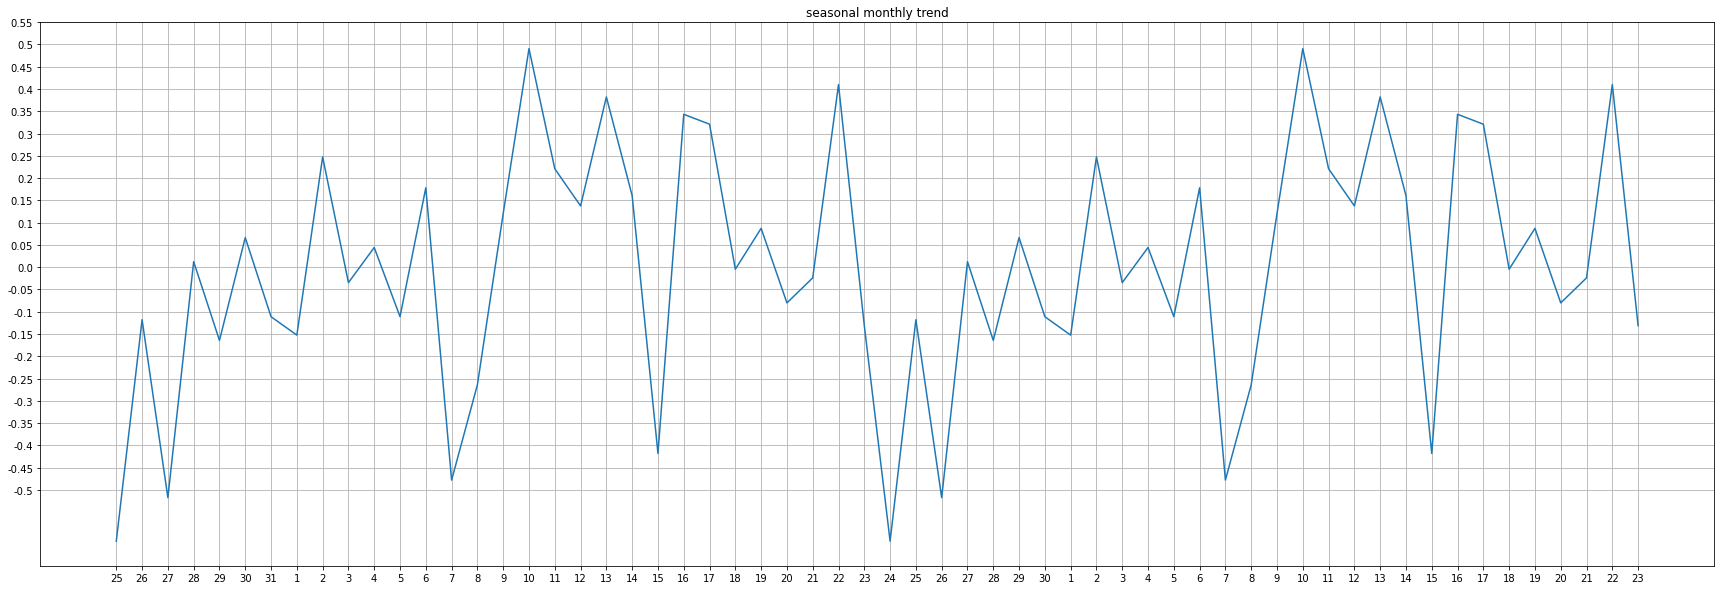

In [6]:
# Time series decomposition, to do a more profound check for seasonal and general trend and for residual component;

result = seasonal_decompose(df['sum'], model='additive',period=30)
plt.rcParams["figure.figsize"] = (30,10)
# plt.plot(df['date'],result.observed.values)
plt.plot(df['date'][14:74],result.seasonal[14:74])
plt.xticks(df['date'][14:74],df['date'][14:74].dt.day)
plt.yticks([i/100 for i in range(-50,60,5)],[i/100 for i in range(-50,60,5)] )
# plt.plot(df['date'],result.resid.values)
plt.grid(True)
plt.title('seasonal monthly trend')

# the monthly trend seems to be: most learning beetween 9 and 14th of the month, decrease at the end of the month 
# and then again increase 

# we will divide each month in 3 parts, make it a feature and create dummy variables for the column 

df['part_of_month'] = np.where(df['date'].dt.day<=10,1,np.where((df['date'].dt.day>10) & (df['date'].dt.day<=20),2, 3 ))
df = pd.get_dummies(df, columns=['part_of_month'], drop_first = True)

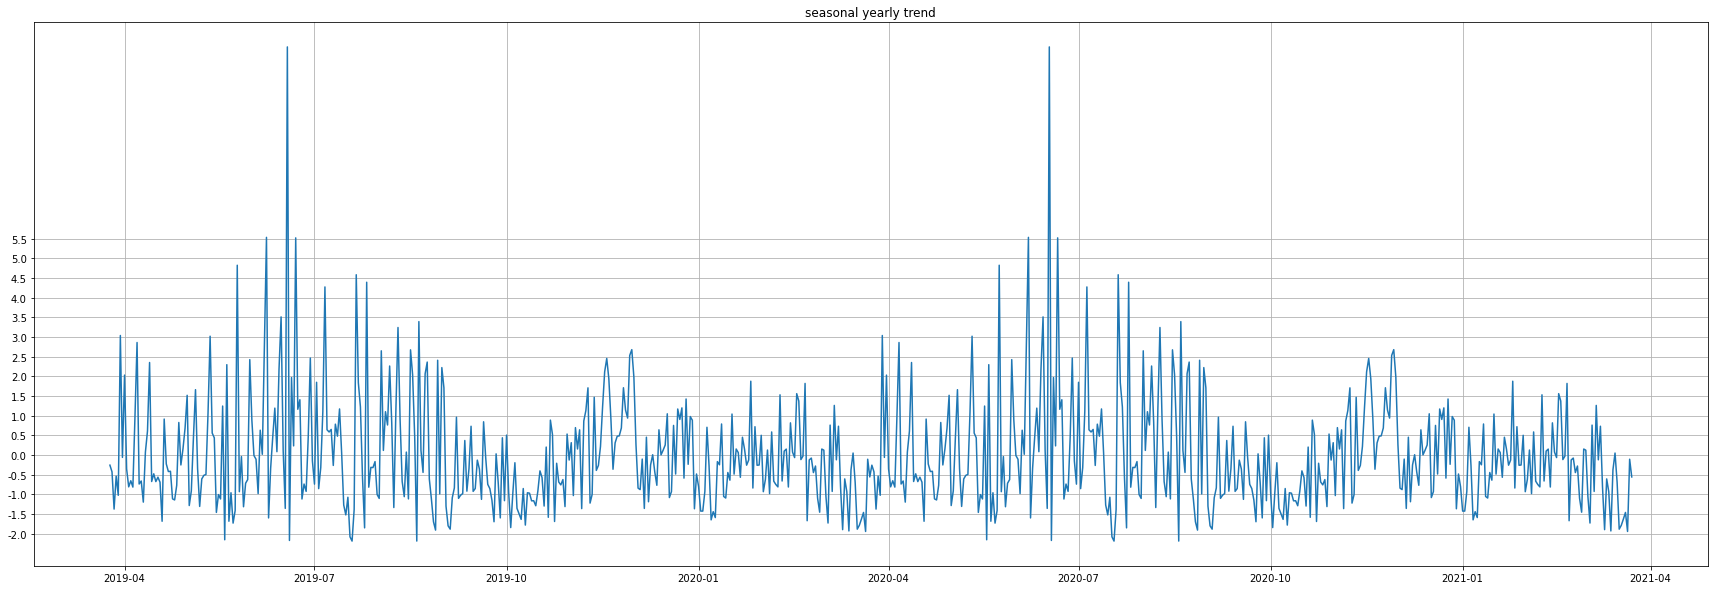

In [7]:
# Time series decomposition, to do a more profound check for seasonal and general trend and for residual component;

result = seasonal_decompose(df['sum'], model='additive',period=365)
plt.rcParams["figure.figsize"] = (30,10)
# plt.plot(df['date'],result.observed.values)
plt.plot(df['date'][14:744],result.seasonal[14:744])
plt.yticks([i/100 for i in range(-200,600,50)],[i/100 for i in range(-200,600,50)] )
# plt.plot(df['date'],result.resid.values)
plt.grid(True)
plt.title('seasonal yearly trend')

# the yearly trend seems to be: most learning in summer, then decreasing, small peak late autumn and early winter,
# low values in the winter and increasing to again peak in summer 
# We will create time features encoded as sine/cosine transformations

df['q_sin'] = np.sin(2 * np.pi * (df['date'].dt.quarter)/4)
df['q_cos'] = np.cos(2 * np.pi * (df['date'].dt.quarter)/4)

df['month_sin'] = np.sin(2 * np.pi * (df['date'].dt.month)/12)
df['month_cos'] = np.cos(2 * np.pi * (df['date'].dt.month)/12)

df['wok_sin'] = np.sin(2 * np.pi * (df['date'].dt.isocalendar().week)/52)
df['wok_cos'] = np.cos(2 * np.pi * (df['date'].dt.isocalendar().week)/52)


The IQR is 2.7
The lower boundary is -3.750000000000001
The upper boundaryis 7.050000000000001
Total number of outliers are 35


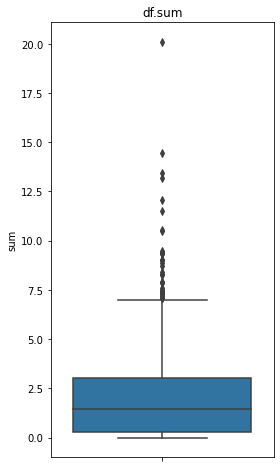

In [8]:
# According to the nature of the dataset (prepared manually without knowing it's future purpose), 
# we suspect a lot of outliers, so we will use boxplot method to identify and remove them

import seaborn as sns

plt.figure(figsize = (4,8))
sns.boxplot(y = df['sum'])
plt.title('df.sum')
    
def outlier_boundaries(df , column):
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # interquantile range
    iqr = q75 - q25
    # outlier boundary
    boundary = iqr * 1.5
    # lower and upper boundary values
    lower, upper = q25 - boundary, q75 + boundary
    print(f'The IQR is {iqr}')
    print(f'The lower boundary is {lower}')
    print(f'The upper boundaryis {upper}')
    # Calculate the number of records below and above lower and above bound value respectively
    df_upper = df[df[column] > upper]
    df_lower = df[df[column] < lower]
    return print(f'Total number of outliers are {len(df_upper) + len(df_lower)}')

outlier_boundaries(df , 'sum')

#  as more than 7 hours of learning is not realistic, the boundary seems right; we drop our outliers

df = df[df['sum']<7.050000000000001]

In [9]:
# creating new variables

job = []

for date in df['date']:
    if date < pd.to_datetime('2018-07-01'):
        job.append(0)
    elif date >=pd.to_datetime('2018-07-01') and date <= pd.to_datetime('2019-11-30'):
         job.append(1)
    elif date >= pd.to_datetime('2019-12-01') and date <= pd.to_datetime('2021-11-30'):
        job.append(2)
    else:
        job.append(3)
        
df['job'] = job

# making dummy variables to deal with categorical feature 'job'

df = pd.get_dummies(df, columns=['job'], drop_first = True)

# adding more variables for circumstances that could affect language learning


df['learningDS']=np.where((df['date'] >='2021-08-01'),1,0)

# subscription gives access to more foreign language content (easier to spend some time learning), but can also distract

df['Netflix']=np.where((df['date'] >='2021-06-15'),1,0)

# while in journey, it is harder to find time to learn

df['journey'] = np.where(df['date'].isin(pd.date_range(start='9/13/2021', end='9/18/2021'))|
                      df['date'].isin(pd.date_range(start='5/11/2022', end='5/22/2022')) |
                        df['date'].isin(pd.date_range(start='9/9/2022', end='9/11/2022')) |
                           df['date'].isin(pd.date_range(start='9/24/2022', end='9/30/2022')) |
                                                df['date'].isin(pd.date_range(start='04/15/2022', end='04/18/2022'))|
                                                     df['date'].isin(pd.date_range(start='08/16/2019', end='08/18/2019')),
                                                        1,0)
                       

# Having more time on holiday could help to learn more
 

holidays = ['06-01-2019', '01-05-2019', '02-05-2019','03-05-2019','15-08-2019','01-11-2019', '11-11-2019', '24-12-2019','22-04-2019',
           '06-01-2020', '01-05-2020', '02-05-2020','03-05-2020','15-08-2020','01-11-2020', '11-11-2020','24-12-2020','13-04-2020',
           '06-01-2021', '01-05-2021', '02-05-2021','03-05-2021','15-08-2021','01-11-2021', '11-11-2021','24-12-2021','05-04-2021',
           '06-01-2022', '01-05-2022', '02-05-2022','03-05-2022','15-08-2022','01-11-2022', '11-11-2022', '18-04-2022']

df['holiday'] = np.where(df['date'].isin(holidays),1,0 | df['date'].dt.dayofweek.isin([5,6]))

# presumably more time spent at home during lockdown could help to learn more
df['covid'] = np.where(df['date'].isin(pd.date_range(start='3/15/2020', end='3/15/2022')),1,0)

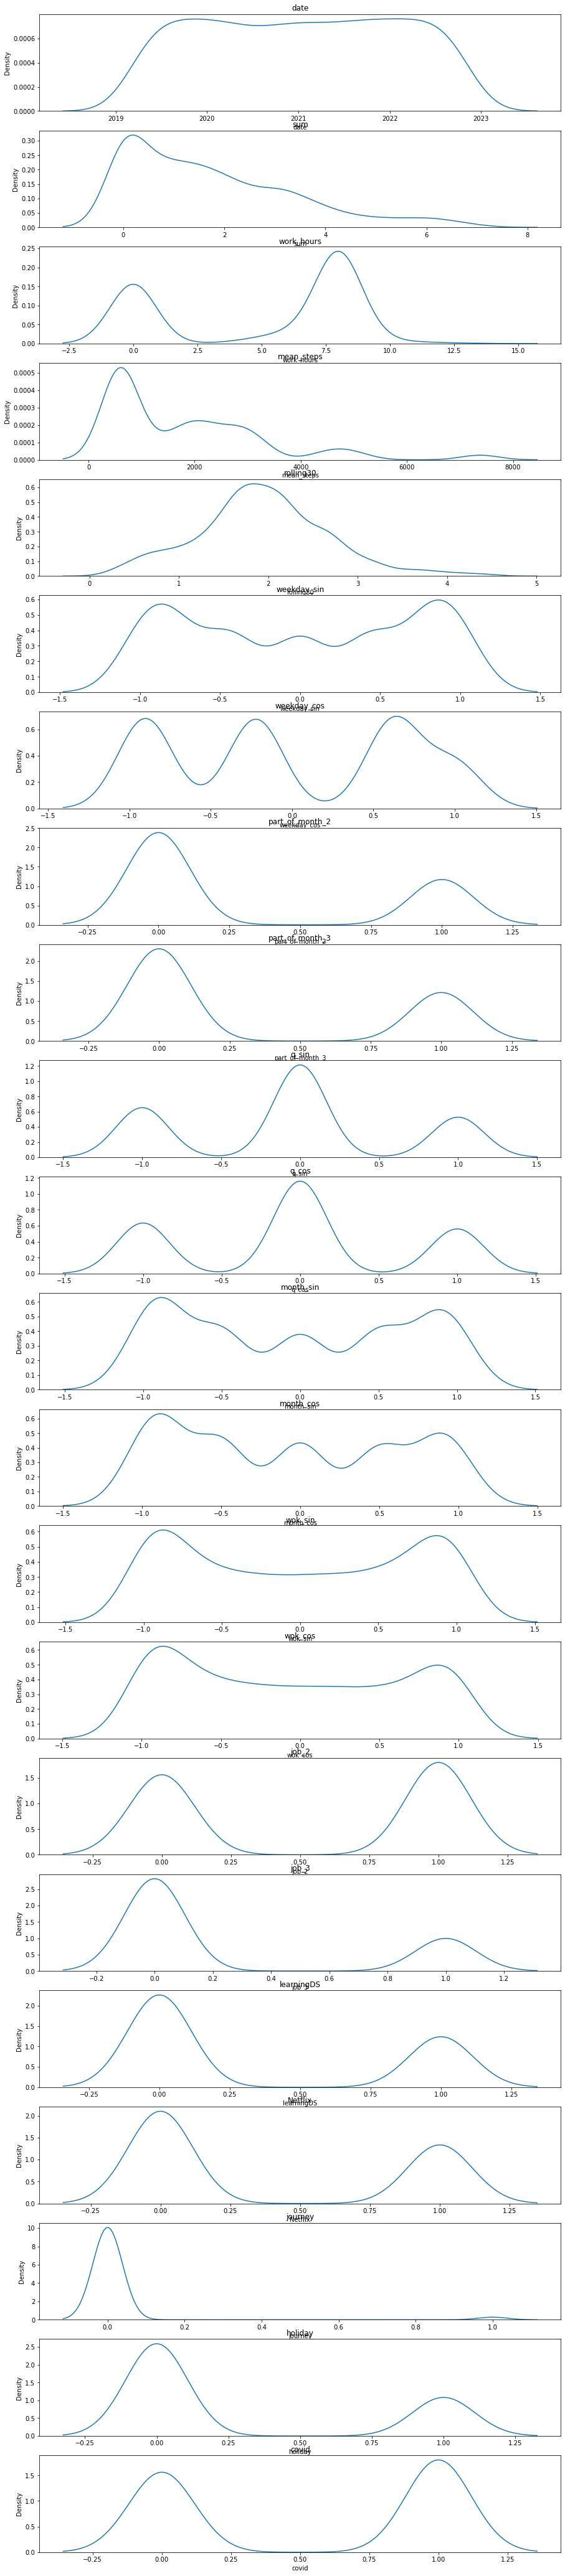

In [10]:
# checking features distribution to catch some mistakes in column creation and check 
# how much the distribution is different from normal distribution in case of continuous features
# we can see that the distribution is not normal for most columns, which might decrease the performance of many ML algorithms
# we will try transforming the skewed columns by square transformations


import seaborn as sns

fig = plt.figure(figsize=(15,75))
position = 1
for i in df.columns[0:len(df.columns)]:
    ax = fig.add_subplot(len(df.columns),1,position)
    position = position + 1
    sns.kdeplot(df[i],ax=ax)
    plt.title(i)



In [11]:
# we have positive skew for columns' avg_course_day and mean_steps; we will try to replace their values with 
# their square root to reduce that and thus improve performance of our models;
# log transformation would be more efficient, but since we have many zeroes in our columns, it cannot be used
# work hours seems to be slightly positively skewed; we will try square of it's value to diminish the effect of skewness

df['mean_steps'] = np.sqrt(df['mean_steps'])
df['work_hours'] = np.power(df['work_hours'], 2)


<AxesSubplot:>

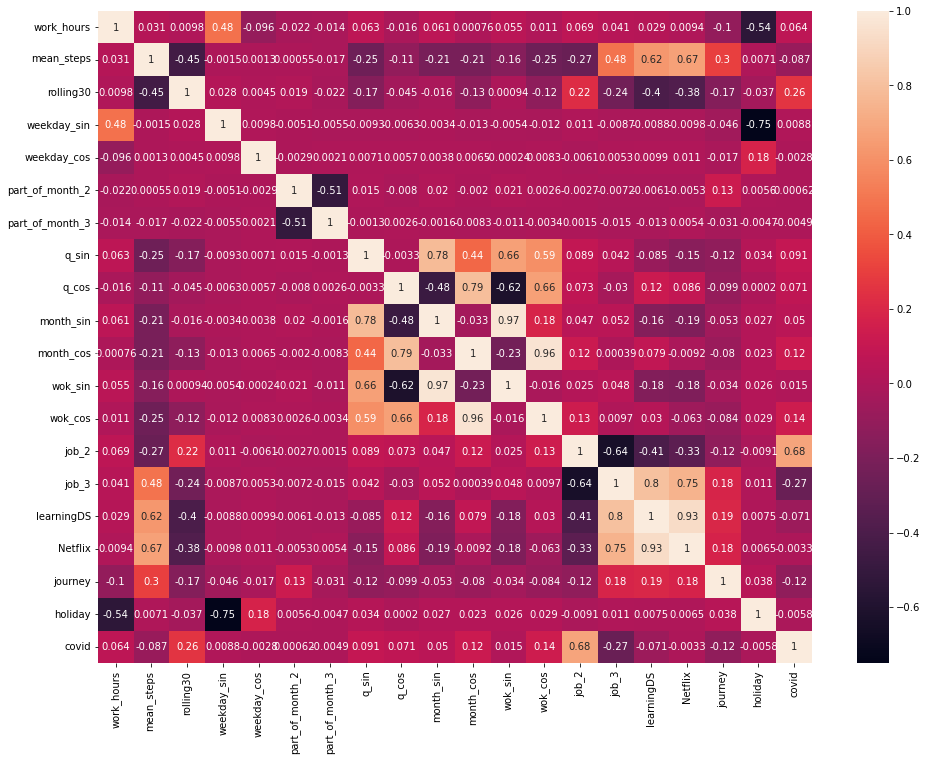

In [12]:
# We make a heatmap to have a glance at correlation of features with target value and with each other 

import seaborn as sns 
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
sns.heatmap(df.iloc[:,2:len(df.columns)].corr(),annot=True)

# we have a lot of correlation between variable pairs;
# we will also use standardization and pca as elements of our model pipeline , which can help to deal with multicollinearity

In [ ]:
#  w100/25

In [13]:
# As we have a lot of features, we will use pca; we will also scale the data as lack of scaling can negatively impact clustering
# algorithms based on distance

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = PCA(n_components=len(df.drop('date', axis=1).columns))
df_clustering = pca.fit_transform(scaler.fit_transform(df.drop('date', axis=1)))

In [14]:
# Using some rules of thumbs found in scientific articles on clustering 
# in order to find right number of principal components
# 4 is very close to 3 which would allow us to visualise the clusters which
# would be a great advantage for reviewing algorithms performance; as using 3 principal components instead of
# 4 actually gives better silhouette scores, we will use 3 principal components

pca_explained_var=pca.explained_variance_ratio_
len_df = len(df_clustering)
mean_variance_explained = 100/len_df
n_components = len([i for i in pca_explained_var if i>=mean_variance_explained])

print(f'Our df has {len_df} features')
print(f'We need each component to explain at least {mean_variance_explained} of the original dataset variance')
print(f'we need {n_components} principal components')

Our df has 1303 features
We need each component to explain at least 0.07674597083653108 of the original dataset variance
we need 4 principal components


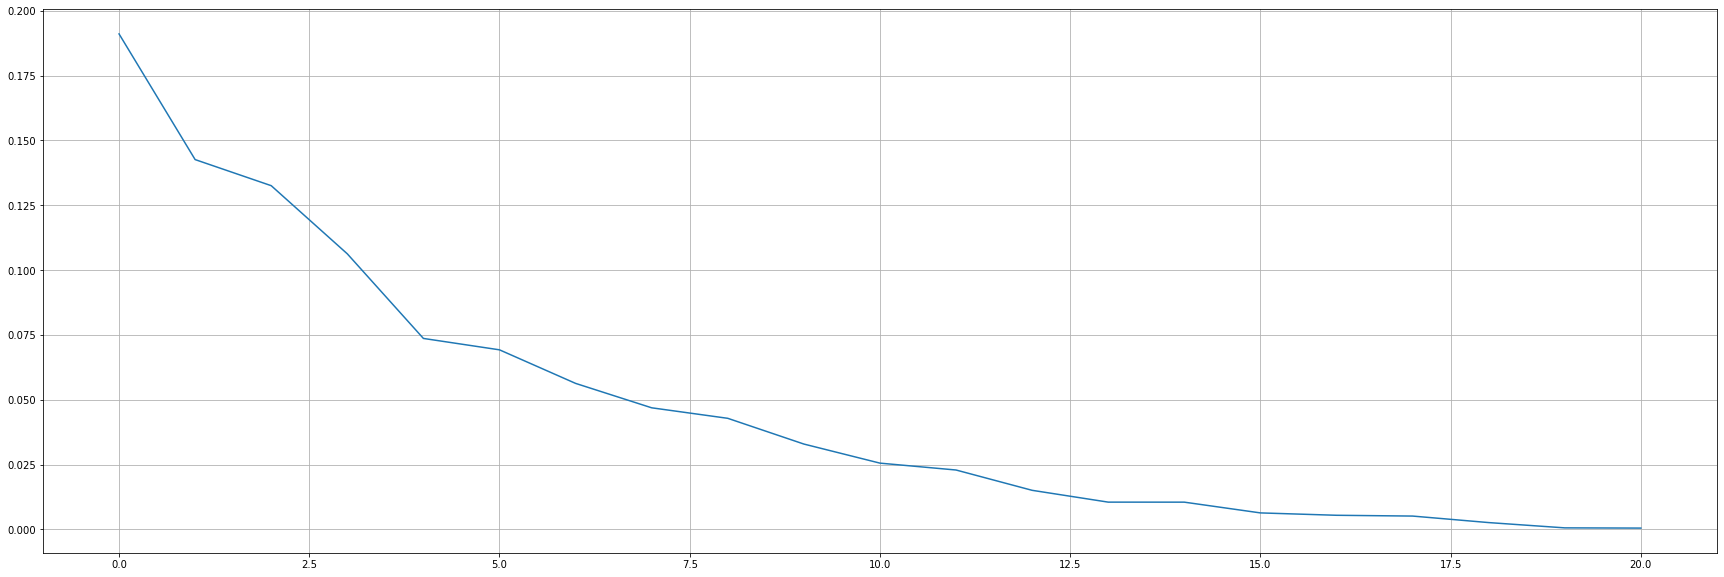

In [16]:
plt.plot(pca_explained_var)
plt.grid("True")

In [17]:
pca_explained_var

array([0.19109447, 0.14263024, 0.13256817, 0.1062854 , 0.07366202,
       0.069268  , 0.05632781, 0.04691106, 0.04285836, 0.03293503,
       0.0255764 , 0.0229243 , 0.01509321, 0.0105367 , 0.01052749,
       0.00638132, 0.00546764, 0.00516152, 0.00265084, 0.00061348,
       0.00052653])

Text(0.5, 1.0, 'Points sorted by distance to the 12th nearest neighbor')

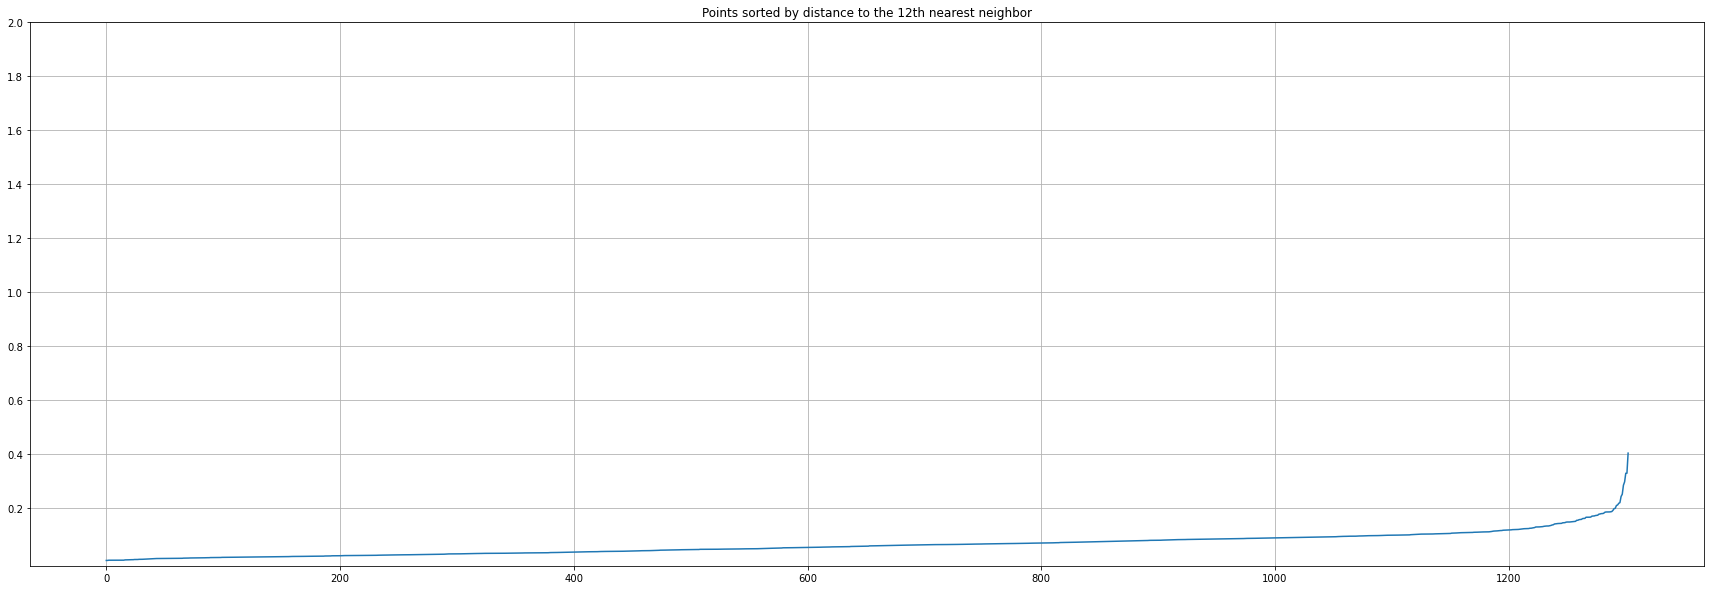

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import math
from sklearn.pipeline import Pipeline

pca= PCA(n_components=3)
prep_pipe = Pipeline([('scaler', scaler),('PCA', pca)])

df_prepped = prep_pipe.fit_transform(df.drop('date', axis=1))

n_neighbors = math.ceil(df_prepped.shape[1]*4)
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(df_prepped)
distances, indices = neighbors_fit.kneighbors(df_prepped)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.yticks(ticks=[0.2,0.4,0.6,0.8,1, 1.2,1.4,1.6,1.8,2])
plt.grid(True)
plt.title(f'Points sorted by distance to the {n_neighbors}th nearest neighbor')

# according to the chart, we should use eps of about 0.5-0.7, however, it is a small value for our dataset,
# resulting in to many points classified as outliers; we will check silhouette score to search for best eps

Our best eps is: 0.65


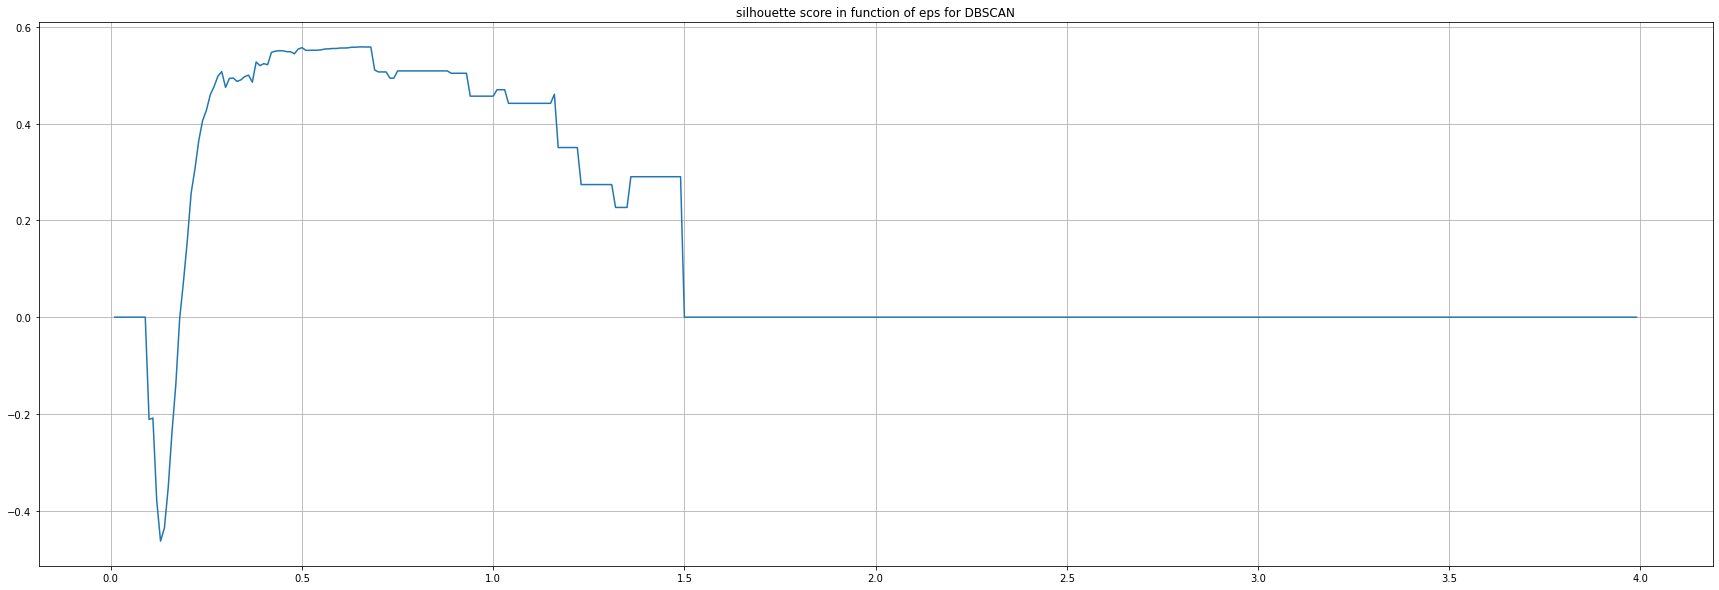

In [19]:
#plotting silhouette score for different values of eps to identify which one is best 
from sklearn.metrics import silhouette_score

sil_scores = []
eps_values = np.arange(0.01, 4, 0.01)

for i in eps_values:
    try:
        dbscan = DBSCAN(eps=i,min_samples=n_neighbors)
        model = dbscan.fit(df_prepped)
        labels = model.labels_
        sil_score = silhouette_score(df_prepped, labels, metric='euclidean')
        sil_scores.append(sil_score)
    except:
        sil_scores.append(0)
        
    
plt.plot(eps_values, sil_scores)
plt.grid()
plt.title('silhouette score in function of eps for DBSCAN')

print('Our best eps is: ' + str(eps_values[sil_scores.index(max(sil_scores))]))


In [20]:
# Our best DBSCAN hyperparameters are:
dbscan = DBSCAN(eps=0.65, min_samples=n_neighbors)
model = dbscan.fit(df_prepped)
labels_dbscan = model.labels_
sil_score = silhouette_score(df_prepped, labels_dbscan, metric='euclidean')
print(f'Silhouette score for the best eps is {sil_score}')
print(pd.value_counts(labels_dbscan))
# We have 13 clusters and 6 outliers

Silhouette score for the best eps is 0.5586379755444844
 1     260
 0     197
 3     181
 2     152
 12     95
 8      90
 4      82
 6      61
 10     49
 13     38
 7      30
 9      26
 5      24
 11     12
-1       6
dtype: int64


Our best n_clusters is 9, it gives silhouette score of 0.5752977673664175 


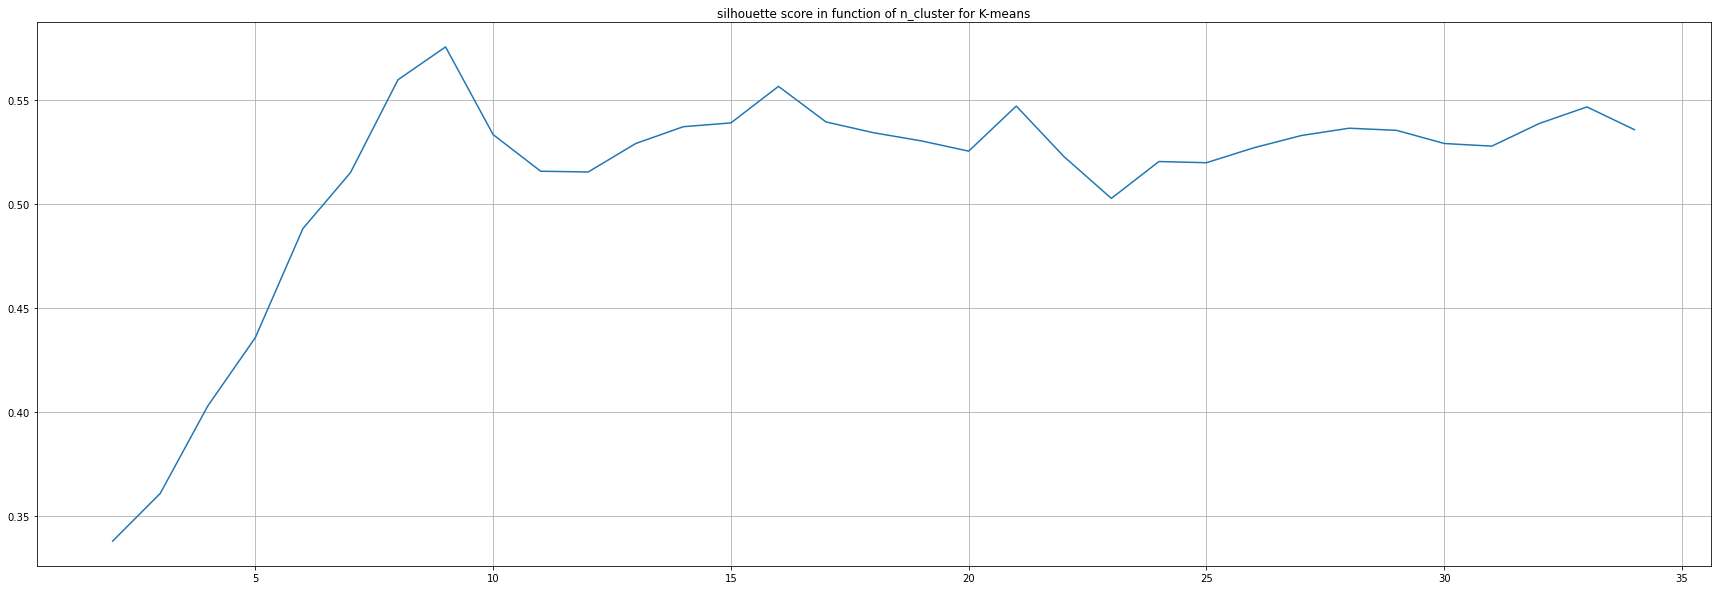

In [21]:
# Let's perform clustering on the same data set using K_Means algorithm
# we have slightly better silhouette score for Kmeans than for DBSCAN
from sklearn.cluster import KMeans

silhouette_scores = []
n_clusters = np.arange(2,35)

for i in n_clusters:
    km = KMeans(init='random', n_clusters=i)
    km.fit(df_prepped)
    labels = km.labels_
    silhouette_score_point = silhouette_score(df_prepped, labels, metric='euclidean')
    silhouette_scores.append(silhouette_score_point)
    

plt.plot(np.arange(2,35),silhouette_scores)
plt.grid()
plt.title('silhouette score in function of n_cluster for K-means')
best_n_clusters = n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f'Our best n_clusters is {best_n_clusters}, it gives silhouette score of {max(silhouette_scores)} ')

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

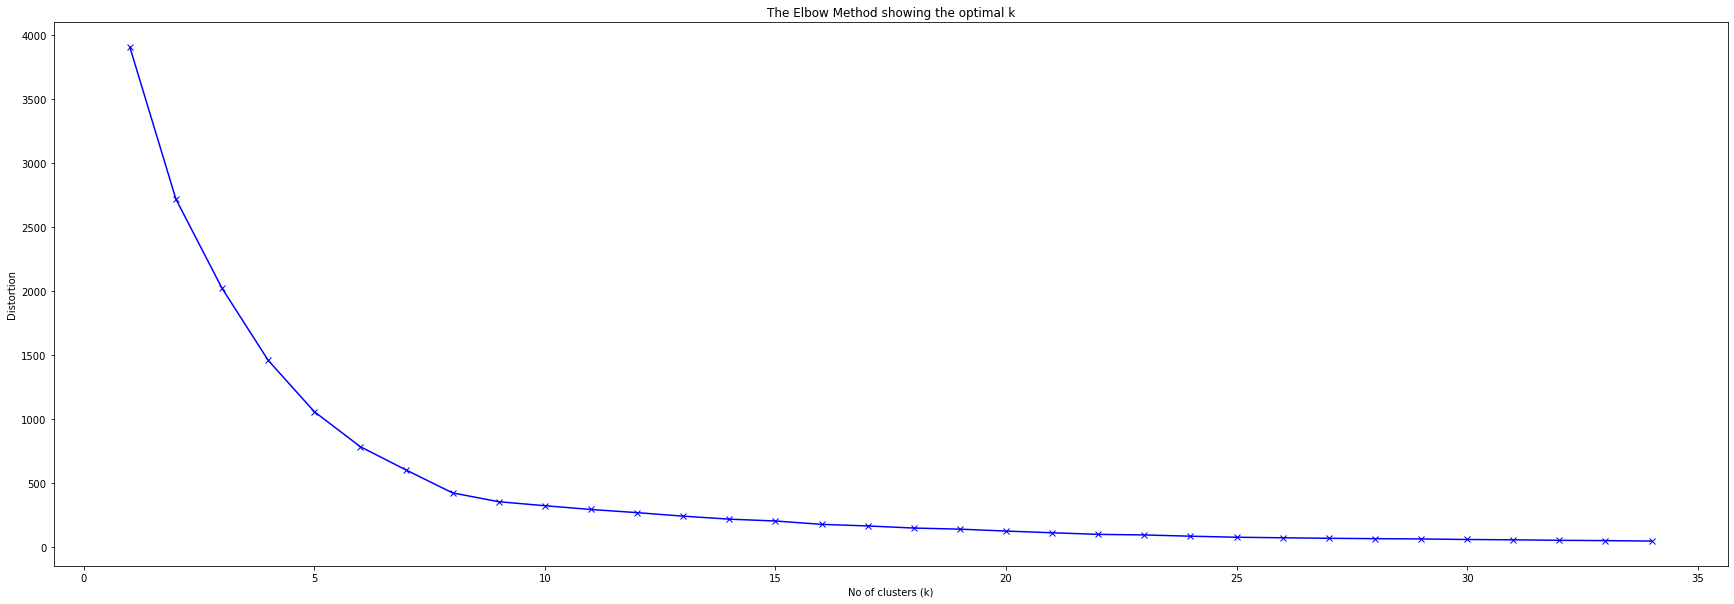

In [22]:
# let's check the results of classic elbow method to determine n_clusters for K_means
distortions = []
K = range(1, 35)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(prep_pipe.fit_transform(df_prepped))
    distortions.append(km.inertia_)
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('No of clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

# The elbow is not really sharp, but we could assume that also 8-9 clusters is reasonable

Text(0.5, 1.0, 'davies bouldin score in function of n_cluster for K-means')

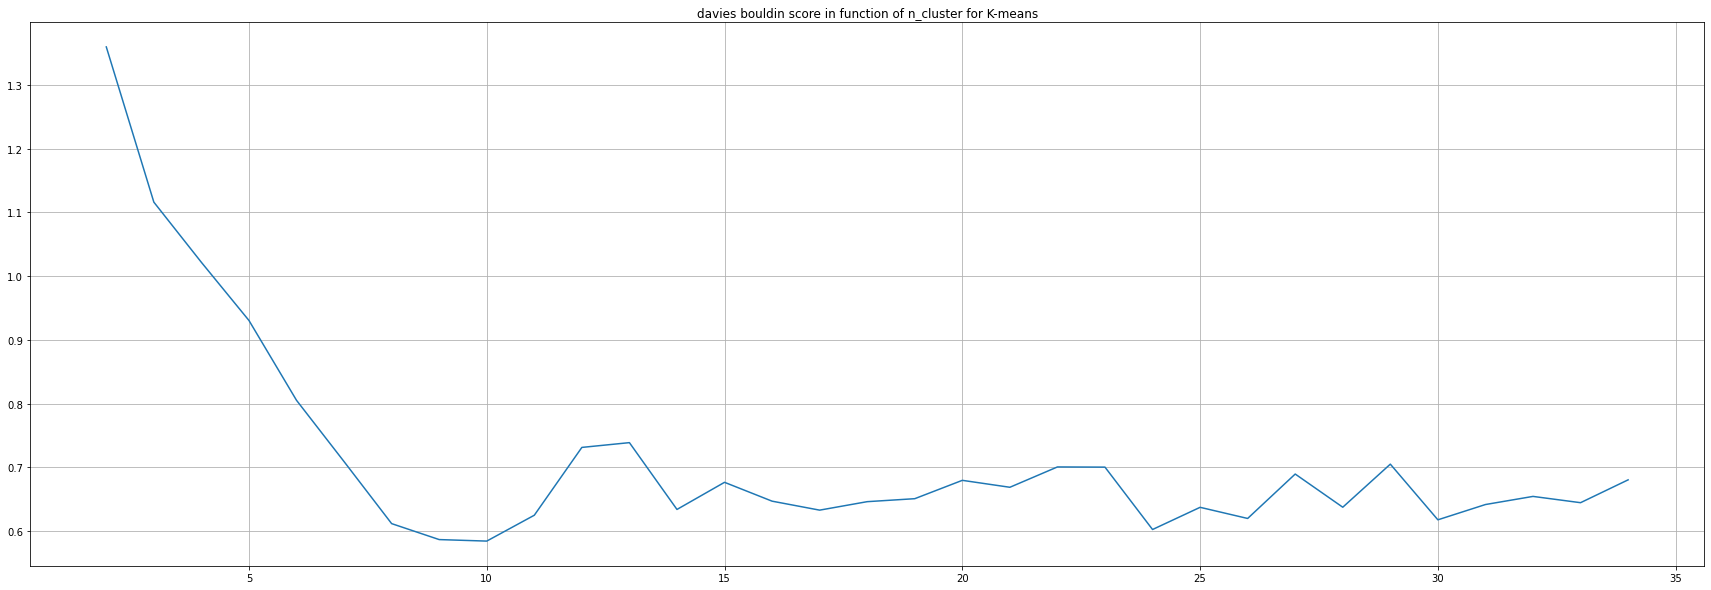

In [23]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_scores = []

for i in np.arange(2,35):
    km = KMeans(init='random', n_clusters=i)
    km.fit(df_prepped)
    labels = km.labels_
    davies_bouldin_point = davies_bouldin_score(df_prepped, labels)
    davies_bouldin_scores.append(davies_bouldin_point)
    

plt.plot(np.arange(2,35),davies_bouldin_scores)
plt.grid()
plt.title('davies bouldin score in function of n_cluster for K-means')
# Another metric gives us 9 as best cluster number for K-means

Our best n_clusters is 10, it gives silhouette score of 0.586988657591106 


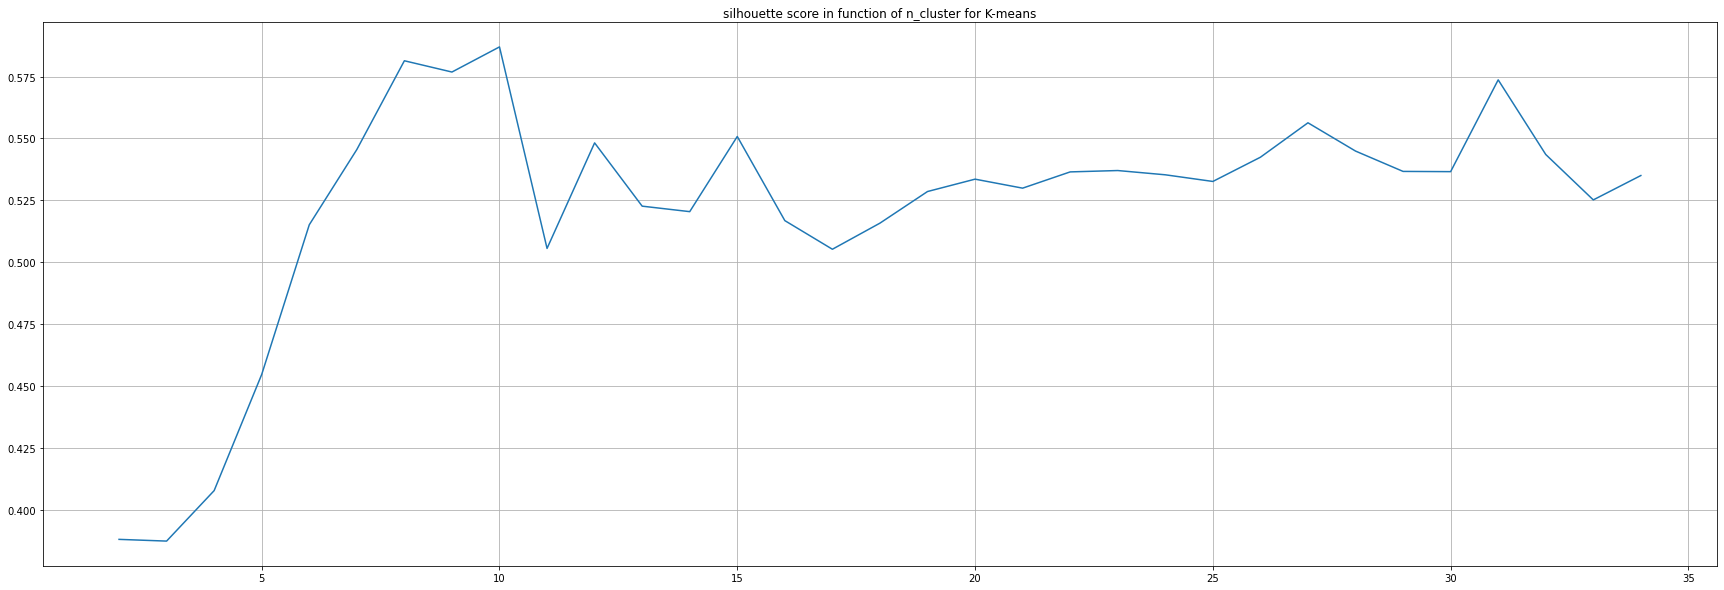

In [24]:
 # we will experiment with removing points marked as outliers by DBSCAN as outliers (K_means is very sensible to outliers) 
# and see if we get different results

df['dbscan'] = dbscan.labels_
df_after_dbscan = df[df['dbscan']!=-1]
df = df.drop('dbscan', axis=1)
df_kmeans_no_outliers = prep_pipe.fit_transform(df_after_dbscan.drop('date', axis=1))

silhouette_scores = []
n_clusters = np.arange(2,35)

for i in n_clusters:
    km = KMeans(init='random', n_clusters=i)
    km.fit(df_kmeans_no_outliers)
    labels = km.labels_
    silhouette_score_point = silhouette_score(df_kmeans_no_outliers, labels, metric='euclidean')
    silhouette_scores.append(silhouette_score_point)
    

plt.plot(np.arange(2,35),silhouette_scores)
plt.grid()
plt.title('silhouette score in function of n_cluster for K-means')
best_n_clusters = n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f'Our best n_clusters is {best_n_clusters}, it gives silhouette score of {max(silhouette_scores)} ')

# Our best score is for 10 clusters, but score for 9 clusters has quite similar values; The silhouette score is slightly better, 
# but not impressive, so we will not remove the points marked by dbscan as outliers

In [26]:
# Saving km_labels for visualisation purposes later on
km = KMeans(init='random', n_clusters=9)
km.fit(df_prepped)
km_labels = km.labels_

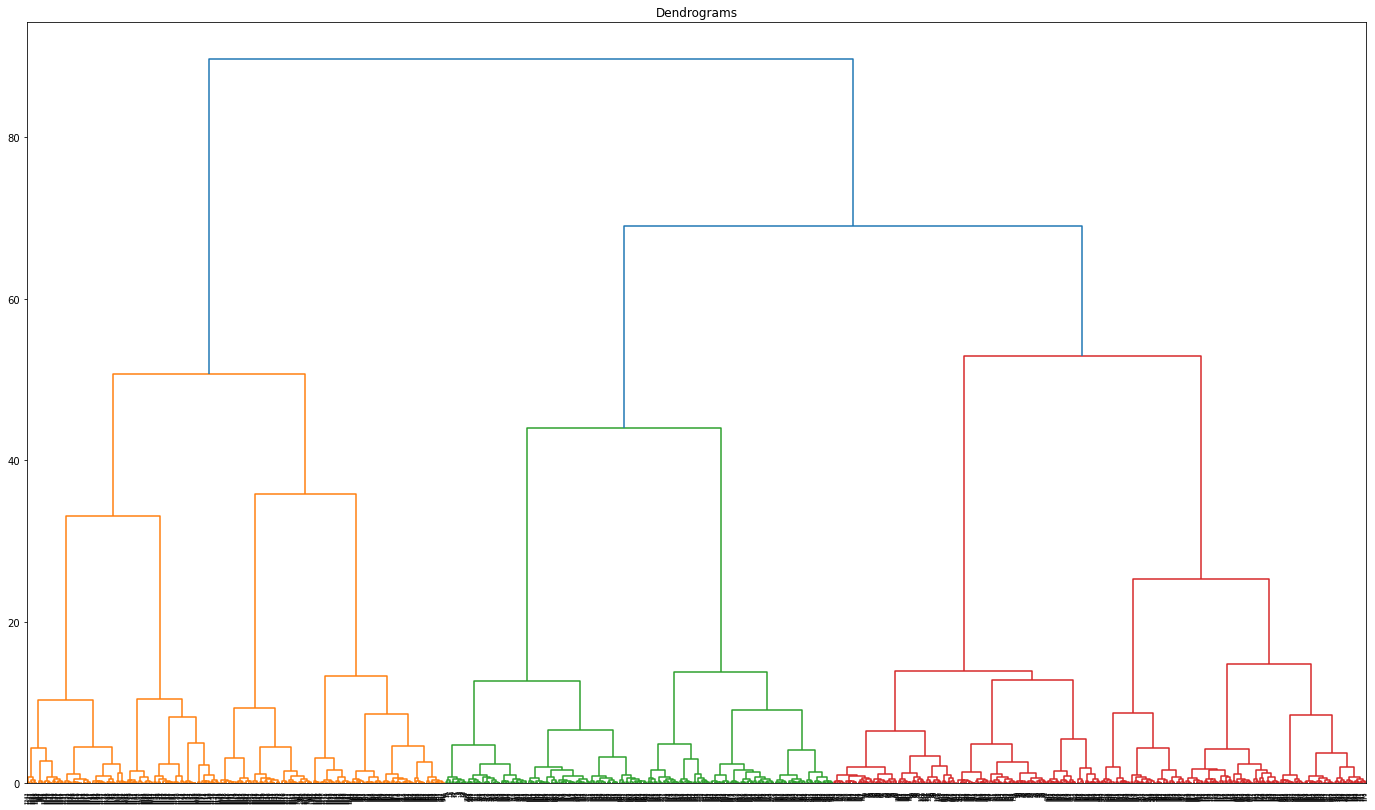

In [29]:
# Let's check what will be the result of agglomerative clustering of our dataset
# Dendrogram gives us totally different cluster number (2-3) than other methods, we will take its results with a grain of salt

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(24, 14))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_prepped, method='ward'))

Our best n_clusters is 9, it gives silhouette score of 0.5731526366224218 


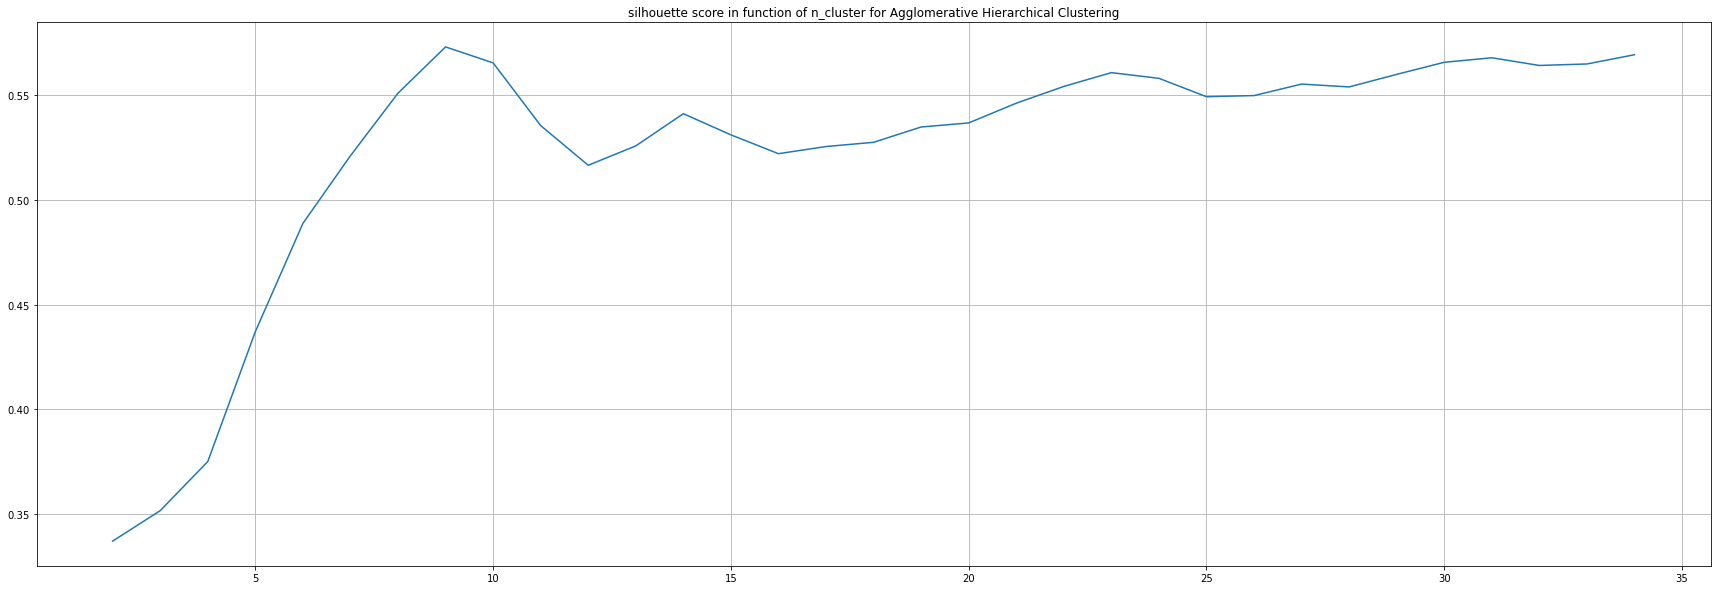

In [30]:
# As 27 clusters is a very high number of clusters, two high as to make clusters' analysis clear and easy to interpret

from sklearn.cluster import AgglomerativeClustering

silhouette_scores = []
n_clusters = np.arange(2,35)

for i in n_clusters:
    agg = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    agg.fit(df_prepped)
    labels = agg.labels_
    silhouette_score_point = silhouette_score(df_prepped, labels, metric='euclidean')
    silhouette_scores.append(silhouette_score_point)
    

plt.plot(np.arange(2,35),silhouette_scores)
plt.grid()
plt.title('silhouette score in function of n_cluster for Agglomerative Hierarchical Clustering')
best_n_clusters = n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f'Our best n_clusters is {best_n_clusters}, it gives silhouette score of {max(silhouette_scores)} ')

# Our best score is for 26 clusters, but score for 18 clusters has quite similar values; 
# although  it is still far form optimal, we might consider using 18 clusters for analysis

In [31]:
# saving agglomerative clustering labels for later
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
labels_agg = cluster.fit_predict(df_prepped)
pd.value_counts(labels_agg)


1    260
5    197
2    181
0    176
4    129
7     97
3     91
6     90
8     82
dtype: int64

In [32]:
# adding clustering results to df
df['agglomerative'] = labels_agg
df['dbscan'] = labels_dbscan
df['kmeans'] = km_labels

In [33]:
# preparing points for our clustering methods visual comparison
df_prepped = pd.DataFrame(df_prepped, columns = ['pc1','pc2','pc3'])
df_prepped['agglomerative'] = labels_agg
df_prepped['dbscan'] = labels_dbscan
df_prepped['kmeans'] = km_labels
df_prepped.head()

,pc1,pc2,pc3,agglomerative,dbscan,kmeans
0,-1.713150,-0.668987,1.958039,5,0,5
1,-1.754256,-0.684214,1.855871,5,0,5
2,-1.944607,-0.751382,1.806985,5,0,5
3,-1.751369,-0.692327,1.853647,5,0,5
4,-1.562577,-0.640531,2.010457,5,0,5


<IPython.core.display.Javascript object>


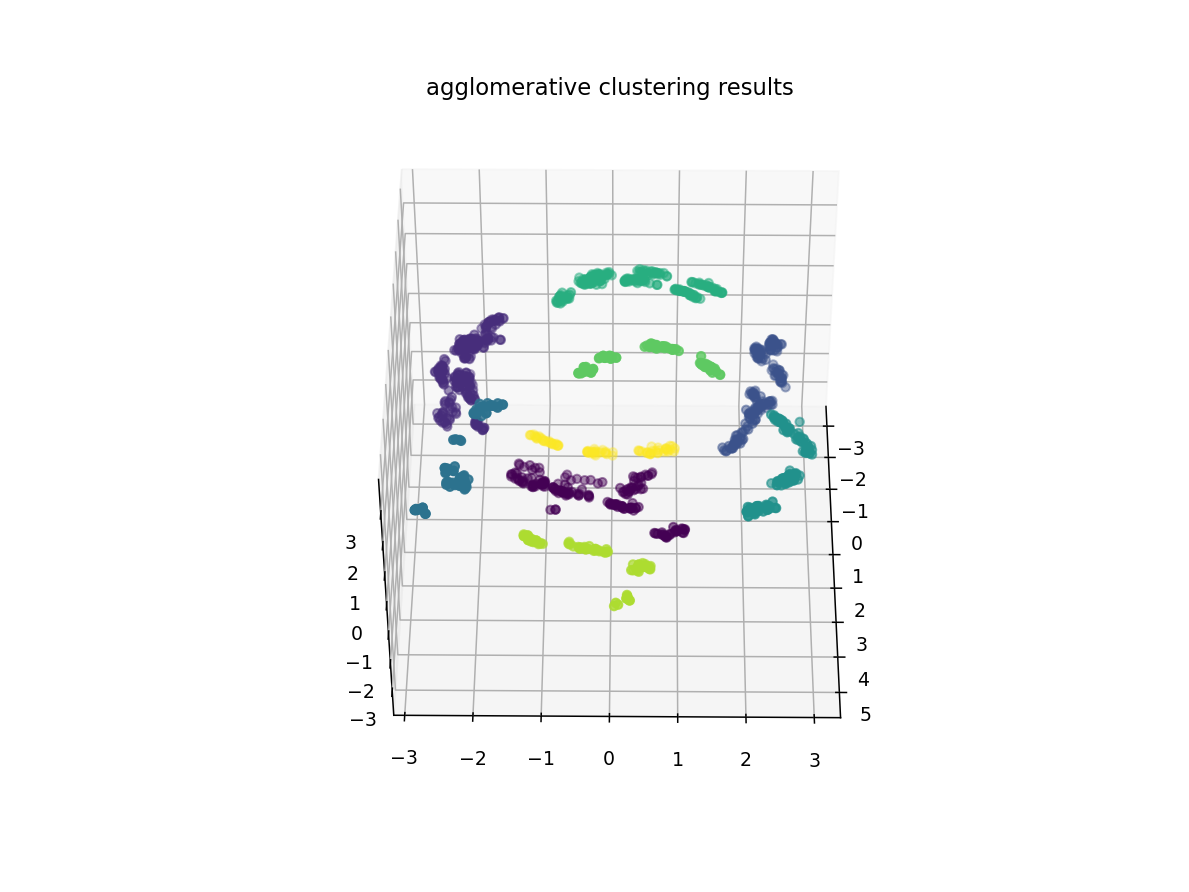

Text(0.5, 0.92, 'agglomerative clustering results')

In [34]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_prepped['pc1'], df_prepped['pc2'], df_prepped['pc3'], c=df_prepped['agglomerative'])
plt.title('agglomerative clustering results')

# After rotating the figure we can see right away that the algorithm did a great good job

<IPython.core.display.Javascript object>


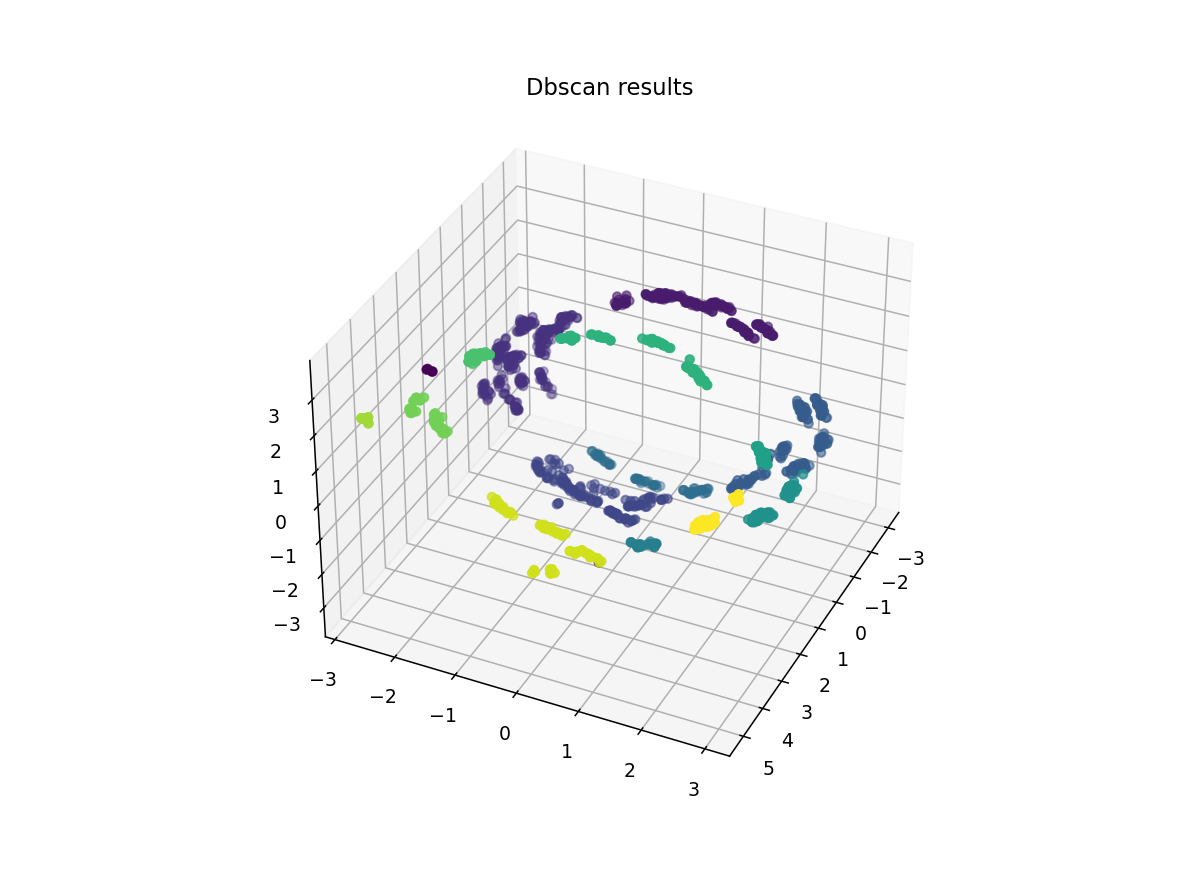

Text(0.5, 0.92, 'Dbscan results')

In [35]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_prepped['pc1'], df_prepped['pc2'], df_prepped['pc3'], c=df_prepped['dbscan'])
plt.title('Dbscan results')

# Dbscan also gives good results, but we see some purple single points which could have been assigned better; 
# also the yellow 





<IPython.core.display.Javascript object>


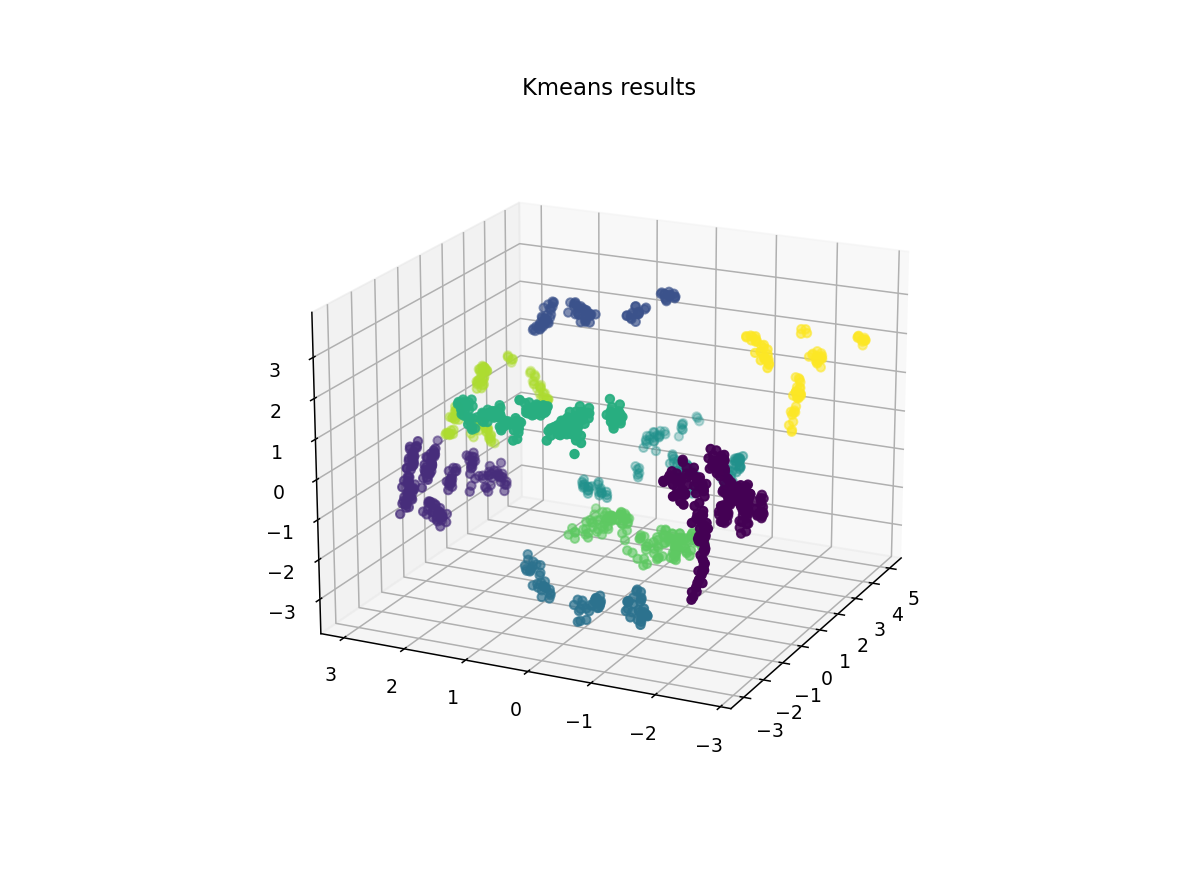

Text(0.5, 0.92, 'Kmeans results')

In [36]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_prepped['pc1'], df_prepped['pc2'], df_prepped['pc3'], c=df_prepped['kmeans'])
plt.title('Kmeans results')

# K-means  also did very well judging from the visual representation

In [53]:
# We can analyze clusters to see how they translate to feature values; 
# in order to do first check we can compare basic statistics of all population vs each cluster
print('population: ')
print(df[['sum', 'work_hours', 'mean_steps','learningDS', 'job_2']].describe())
print('================================================================')
print('cluster: ')
print(df[['sum', 'work_hours', 'mean_steps','learningDS', 'job_2', 'kmeans' ]][df['kmeans']==8].describe())
# cluster 0 - above average language learning,a bit below average working hours,a bit below average steps,mostly job 2, mostly not learning ds
# cluster 1 - above average language learning, working a bit below 8hrs/day,steps below average, mostly job 2, mostly not learning ds
# cluster 2- quite below average language learning,a lot of steps, working a lot,job 2,already learning ds
# cluster 3 - a lot of language learning,a bit more than average working hours,mostly job 2, mostly learning ds
# cluster 4 - average language learning, above avg steps,a bit less than avg work hours,mostly not job 2, learning ds already
# cluster 5 - average language learning,few steps,working abit above average,mostly job 2, not learning ds yet
# cluster 6 - a bit below average language learning, average steps, working a bit below avg, mostly not job 2, mostly not learning ds
# cluster 7 - below average language learning,average working hours, a lot of steps, job 2/3, already learning ds
# cluster 8 - little language learning, quite a lot of steps, working a lot, job 2 mostly, already learning ds

population: 
               sum   work_hours   mean_steps   learningDS        job_2
count  1303.000000  1303.000000  1303.000000  1303.000000  1303.000000
mean      1.750090    39.939530    39.121404     0.353799     0.535687
std       1.666639    31.887018    16.184541     0.478331     0.498916
min       0.000000     0.000000    24.494897     0.000000     0.000000
25%       0.266667     0.000000    24.494897     0.000000     0.000000
50%       1.400000    64.000000    38.832976     0.000000     1.000000
75%       2.783333    64.000000    52.019227     1.000000     1.000000
max       7.000000   169.000000    85.883642     1.000000     1.000000
cluster: 
             sum  work_hours  mean_steps  learningDS  job_2  kmeans
count  91.000000   91.000000   91.000000        91.0   91.0    91.0
mean    1.143407   42.901099   60.324149         1.0    0.0     8.0
std     1.634738   30.252660   19.240215         0.0    0.0     0.0
min     0.000000    0.000000   40.533936         1.0    0.0     8.

In [54]:
df_pairplots = df[['sum', 'work_hours', 'mean_steps', 'kmeans' ]]

In [63]:
df_pairplots[df_pairplots['kmeans'].isin([0,1,2,3])]

,sum,work_hours,mean_steps,kmeans
21,3.883333,0.0,24.494897,0
22,1.833333,36.0,24.494897,0
23,2.516667,0.0,24.494897,0
24,1.116667,25.0,24.494897,0
25,0.000000,49.0,24.494897,0
...,...,...,...,...
1112,0.966667,0.0,49.457052,2
1113,0.000000,64.0,49.457052,2
1114,0.666667,64.0,49.457052,2
1115,0.416667,64.0,49.457052,2


<IPython.core.display.Javascript object>


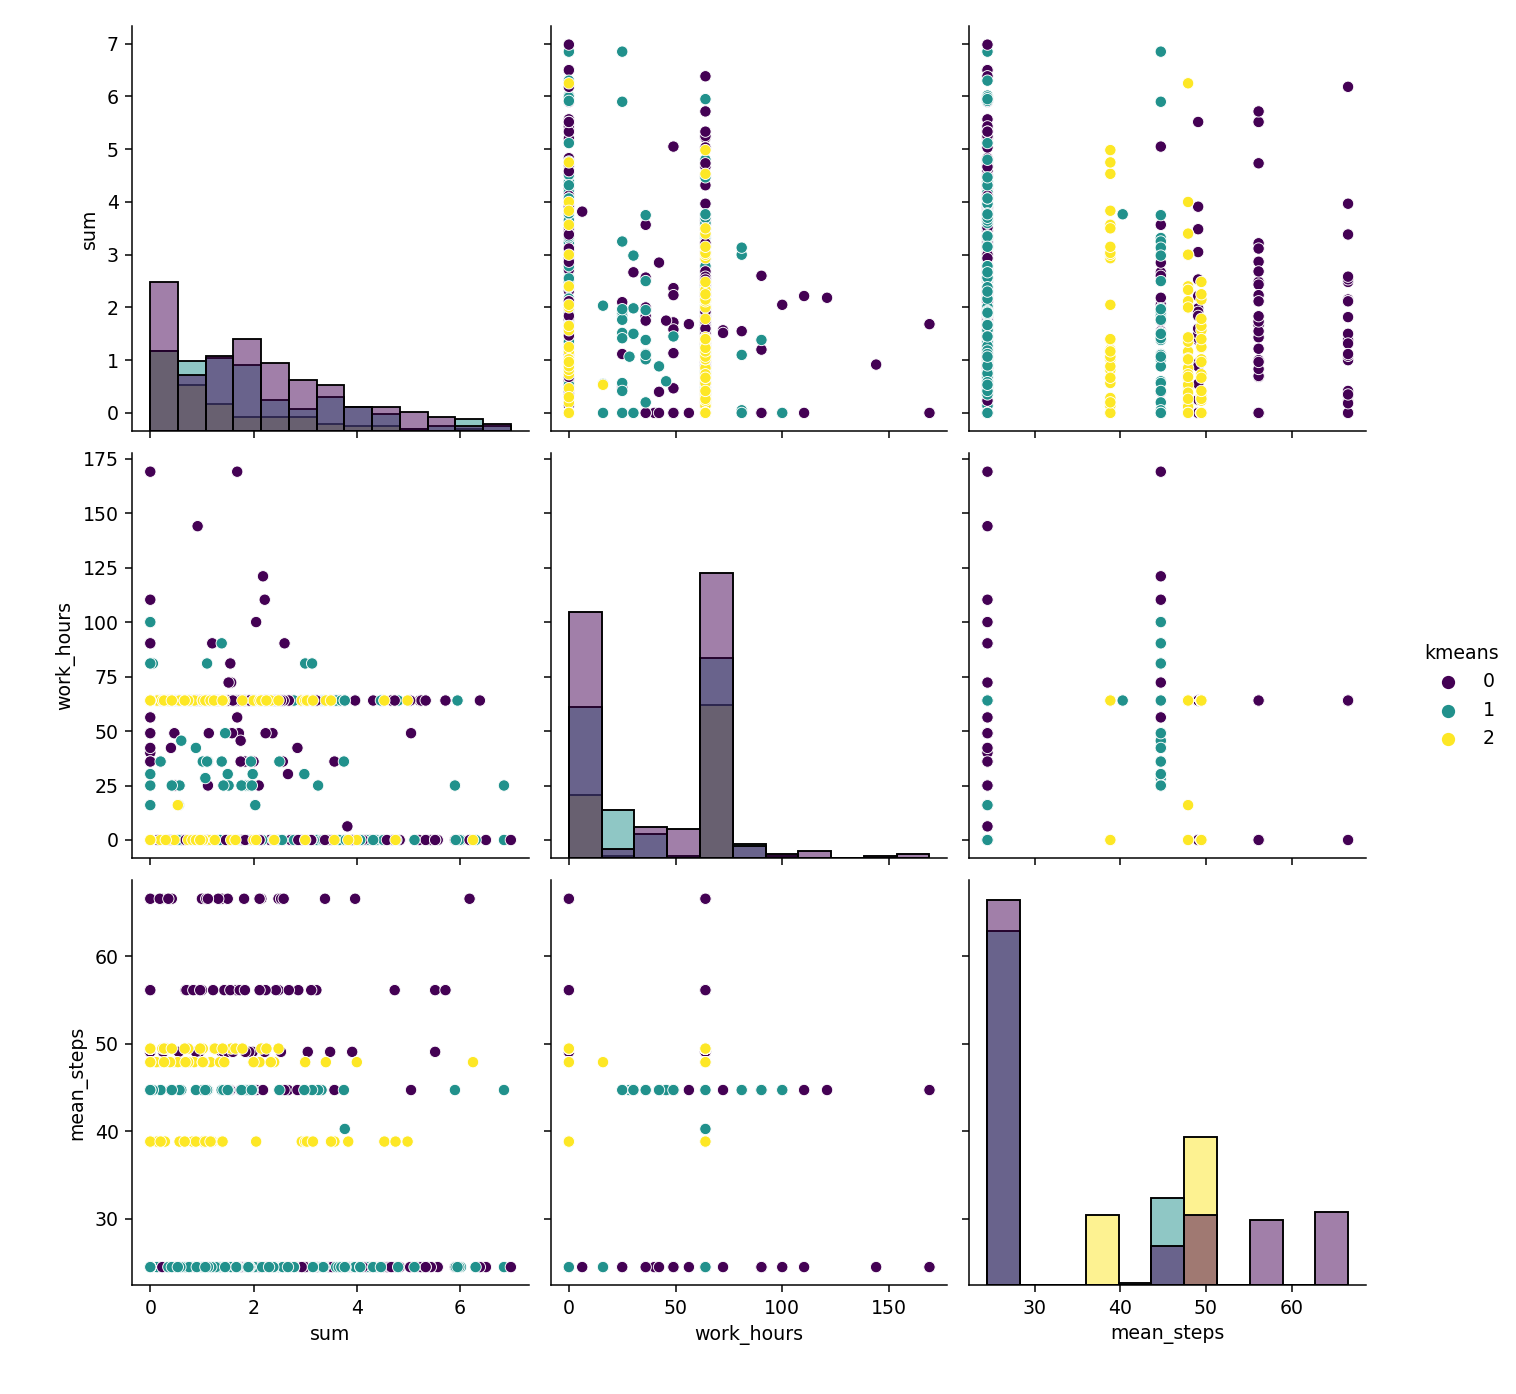

In [65]:
import seaborn as sns
sns.set_palette('viridis')
sns.pairplot(df_pairplots[df_pairplots['kmeans'].isin([0,1,2])], hue='kmeans',diag_kind='hist', palette = 'viridis')

<IPython.core.display.Javascript object>


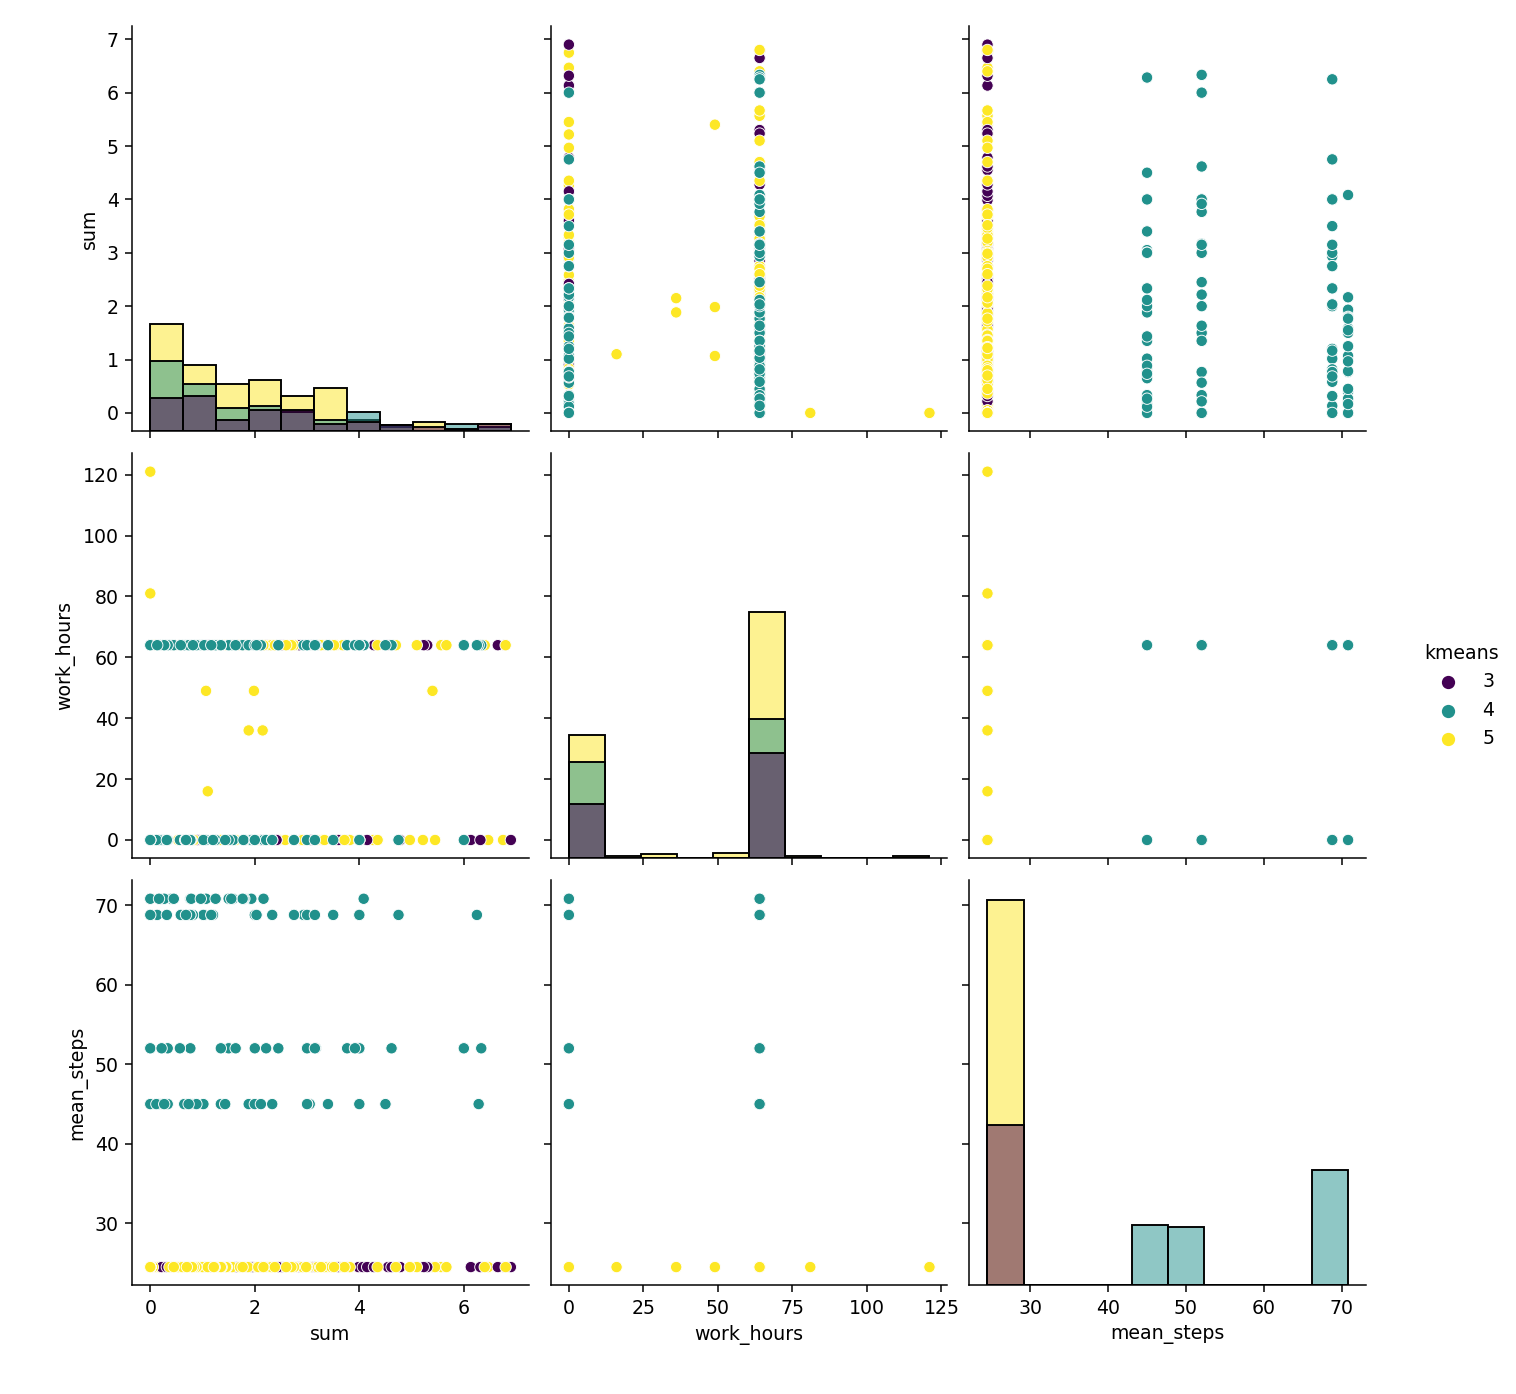

In [68]:
import seaborn as sns
sns.set_palette('viridis')
sns.pairplot(df_pairplots[df_pairplots['kmeans'].isin([3,4,5])], hue='kmeans', diag_kind='hist',palette = 'viridis')

<IPython.core.display.Javascript object>


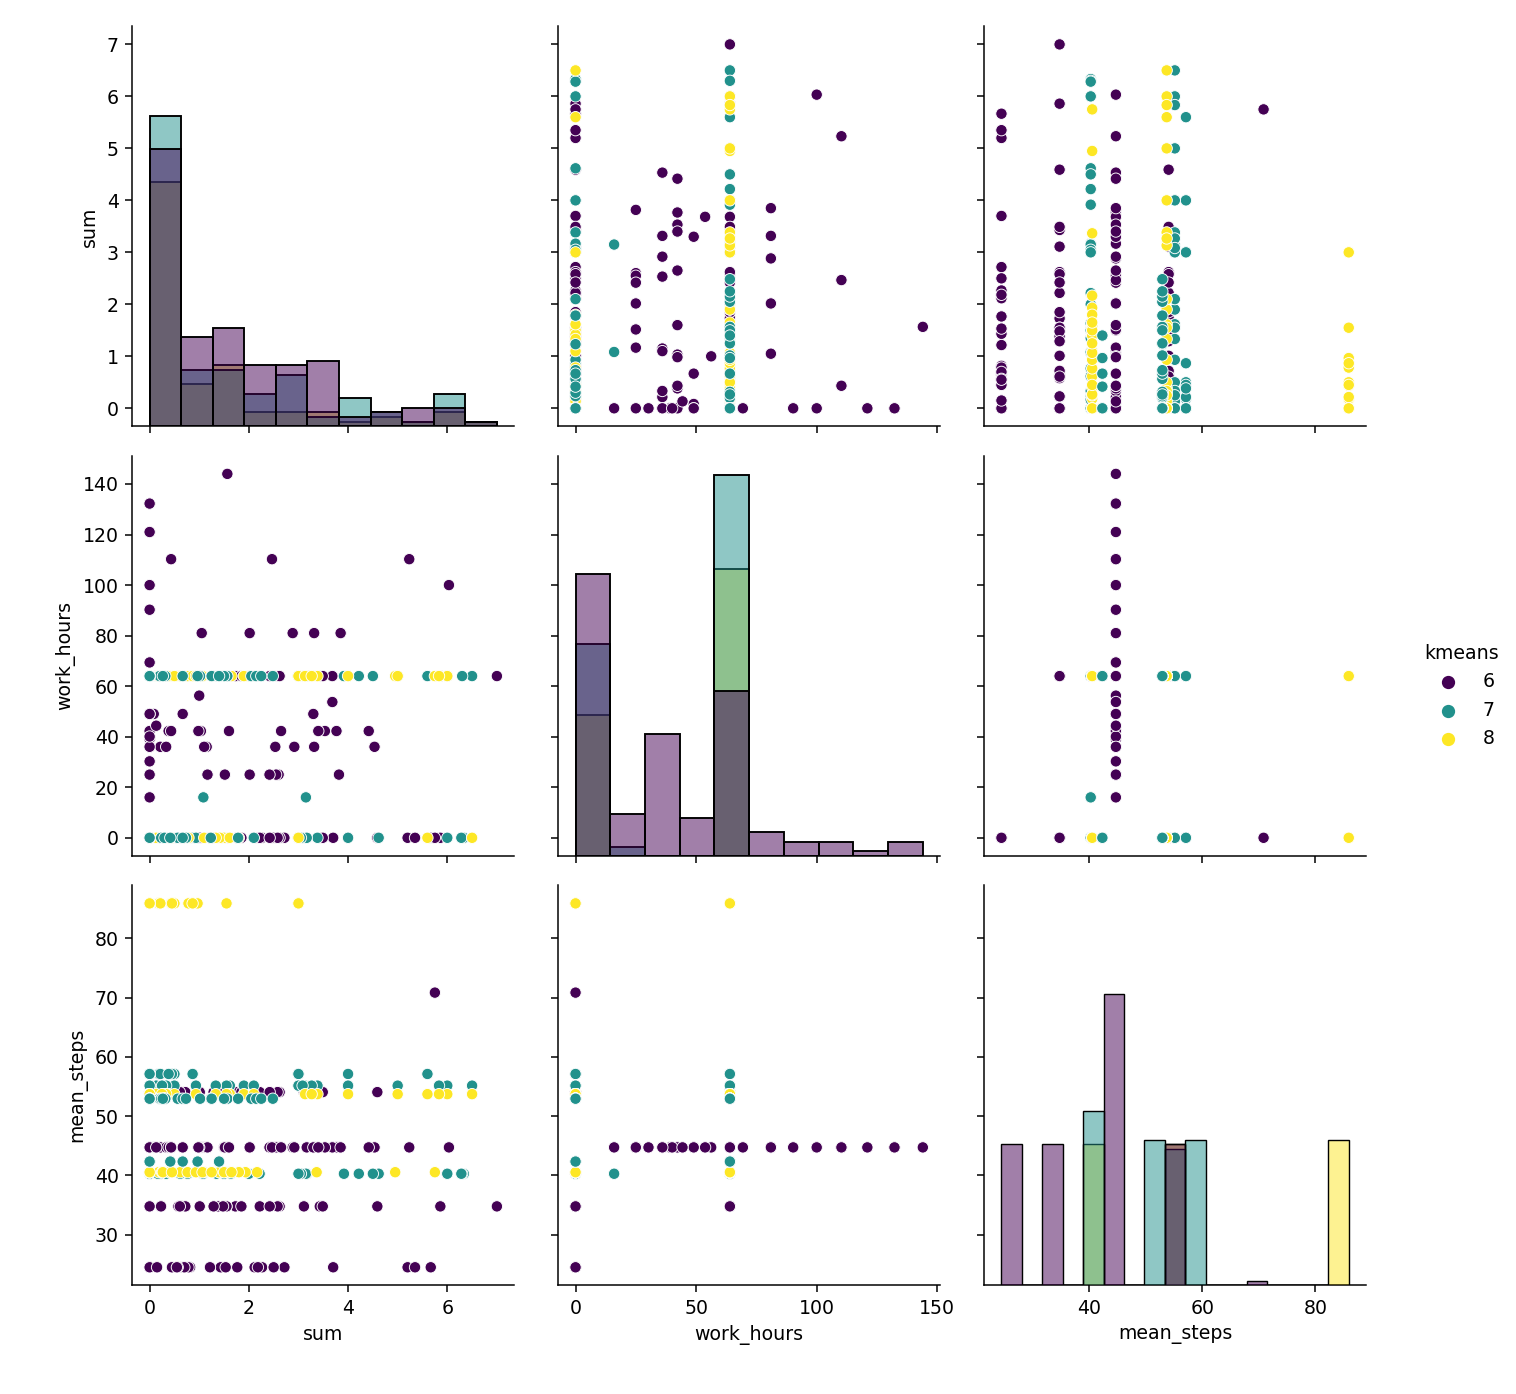

In [69]:
import seaborn as sns
sns.set_palette('viridis')
sns.pairplot(df_pairplots[df_pairplots['kmeans'].isin([6,7,8])], hue='kmeans', diag_kind='hist',palette = 'viridis')